---
Title: "[XAI] Homework 1 - Assessing fairness in a model"
author: "Paweł Wojciechowski"

format:
  html:
    code: false
    echo: false
---

# [XAI] Homework 1 - Assessing fairness in a model

# Task 1

We denote:
- $C$ as a protected attribute (color of the group)
- $\hat{y}$ as a predicted label
- $y$ as a true label

#### Demographic parity

We wish ratio will satisfy $$ \frac{P(\hat{y}=1 | C=0)}{P(\hat{y}=1 | C=1)} \in [0.8;\, 1.2]$$

but the used decision rule had a ratio:

$$ \frac{P(\hat{y}=1 | C=0)}{P(\hat{y}=1 | C=1)} = \frac{0.5}{0.65} \approx 0.77$$


#### Equal opportunity

$$\frac{P\hat{y}=1| y=1, C=0}{P\hat{y}=1| y=1, C=1} = \frac{0.5}{0.75} \approx 0.666$$


#### Predictive rate parity

$$\frac{P(y=1 | \hat{y}=1, C=0)}{P(y=1 | \hat{y}=1, C=1)} \approx \frac{0.5}{0.923} \approx 0.54$$


The used decision rule is not fair according calculated fairness metrics. To improve fairness, we could increase the percentage of enrollment in XAI course in Red group.

# Task 2

## Dataset overview and model

I selected the Adult dataset from the UCI repository. The target variable is binary and indicates whether the income is above 50k or not and contains demographic information about the person.

I will use Logistic Regression and Random Forest models.

I selected 'sex' feature as a protected attribute on which I will assess fairness of used models.



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score




In [2]:

columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
           'marital-status', 'occupation', 'relationship', 'race', 
           'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 
           'native-country', 'income']

protected_attributes = ['age', 'race', 'sex']


train_data = pd.read_csv('datasets/adult/raw/adult.data', 
                         names=columns, 
                         sep=',\s*',
                         na_values='?')
test_data = pd.read_csv('datasets/adult/raw/adult.test', 
                        names=columns, sep=',\s*', skiprows=1,  na_values='?')
test_data['income'] = test_data['income'].str.replace('.', '', regex=False)

train_data.replace({'income': {'<=50K': 0, '>50K': 1}}, inplace=True)
test_data.replace({'income': {'<=50K': 0, '>50K': 1}}, inplace=True)


X_train = train_data.drop(columns='income')
y_train = train_data['income']

X_test = test_data.drop(columns='income')
y_test = test_data['income']

/tmp/ipykernel_64925/953743376.py:9: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



/tmp/ipykernel_64925/953743376.py:13: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
def statistical_parity(X_protected, y, y_pred) -> float:
    positive_share = {}

    for group in X_protected.unique():
        idx = X_protected == group

        y_hat = y_pred[idx]

        positive_share[group] = y_hat.mean()
    return positive_share

def equal_opportunity(X_protected, y, y_pred) -> float:
    tpr_dict = {}
    
    for group in X_protected.unique():
        idx = X_protected == group
        
        y_true = y[idx]
        y_hat = y_pred[idx]
        
        tpr = recall_score(y_true, y_hat)
        
        tpr_dict[group] = tpr
    
    return tpr_dict

def predictive_parity(X_protected, y, y_pred) -> float:
    fpr_dict = {}
    
    for group in X_protected.unique():
        idx = X_protected == group
        
        y_true = y[idx]
        y_hat = y_pred[idx]
        
        tn, fp, _, _ = confusion_matrix(y_true, y_hat).ravel()
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        
        fpr_dict[group] = fpr
    
    return fpr_dict


def measure_performance(y_true, y_pred, y_score=None):
    if y_score is not None:
        y_pred = (y_score >= 0.5).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_score) if y_score is not None else roc_auc_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }
    return metrics


def aggregate_fairness_metrics(X_protected, y_true, y_pred):
    sp = statistical_parity(X_protected, y_true, y_pred)
    eo = equal_opportunity(X_protected, y_true, y_pred)
    pp = predictive_parity(X_protected, y_true, y_pred)
    
    metrics = {
        'statistical_parity_ratio': sp["Female"] / sp["Male"] if sp["Male"] != 0 else None,
        'equal_opportunity_ratio': eo["Female"] / eo["Male"] if eo["Male"] != 0 else None,
        'predictive_parity_ratio': pp["Female"] / pp["Male"] if pp["Male"] != 0 else None
    }
    return metrics

### First model - Logsitic Regression

In [5]:
numerical_features = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'education-num']
categorical_features = ['workclass', 'marital-status', 'occupation', 
                        'relationship', 'race', 'sex', 'native-country']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=0, max_iter=1000))
])

In [6]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'education-num']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=0))])

In [7]:
y_pred = model.predict(X_val)
y_score = model.predict_proba(X_val)[:, 1]

In [8]:
perf =  measure_performance(y_val, y_pred, y_score)
fair = aggregate_fairness_metrics(X_val["sex"], y_val, y_pred)
first_model = {**perf, **fair, 'weight': 1.0, 'type': 'LR'}
first_model

{'accuracy': 0.8581298940580377,
 'auc': 0.9082864731844198,
 'precision': 0.7509697439875873,
 'recall': 0.6161680458306811,
 'statistical_parity_ratio': 0.26765813355451434,
 'equal_opportunity_ratio': 0.6912255603242728,
 'predictive_parity_ratio': 0.25584664000564494,
 'weight': 1.0,
 'type': 'LR'}

## Other model - RandomForest

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=0))
])

In [10]:
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

In [11]:
perf =  measure_performance(y_val, y_pred, y_score)
fair = aggregate_fairness_metrics(X_val["sex"], y_val, y_pred)
second_model = {**perf, **fair, 'weight': 1.0, 'type': "RandomForest"}
second_model

{'accuracy': 0.8581298940580377,
 'auc': 0.9082864731844198,
 'precision': 0.7509697439875873,
 'recall': 0.6161680458306811,
 'statistical_parity_ratio': 0.286791460050704,
 'equal_opportunity_ratio': 0.770891619915335,
 'predictive_parity_ratio': 0.2461490400899976,
 'weight': 1.0,
 'type': 'RandomForest'}

## Applying bias mitigation

To mitigate observed bias, I will set more weight on observations with `sex=Female` during model training.

I will check different weights `[2.0, 5.0, 10.0, 15.0]`  for `Female` observations to see how it affects the fairness and performance of the model. The weights of `Male` observations will be kept to `1.0`.

In [12]:
def create_sample_weights(sex_column, weight_ratio) -> np.ndarray:
    weights = sex_column.map({'Male': 1, 'Female': weight_ratio})
    return weights.values

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=0, max_iter=1000))
])

sample_weights = create_sample_weights(X_train["sex"], weight_ratio=2.0)
model.fit(X_train, y_train, classifier__sample_weight=sample_weights)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'education-num']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=0))])

In [13]:
sample_weight_ratios = [2.0, 5.0, 10.0, 15.0]
results = {}

for ratio in sample_weight_ratios:
    sample_weights = create_sample_weights(X_train["sex"], weight_ratio=ratio)
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=0, max_iter=1000))
    ])
    
    model.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    
    y_pred = model.predict(X_val)
    y_score = model.predict_proba(X_val)[:, 1]
    
    perf = measure_performance(y_val, y_pred, y_score)
    fair = aggregate_fairness_metrics(X_val["sex"], y_val, y_pred)
    
    results[f"LR with weight: {ratio}"] = {**perf, **fair, 'weight': ratio, 'type': 'LR'}

## Models comparison

Below we can see the table with the comparison of the models. The fairness metrics are calculated for the `sex` attribute.

Overall all models have similar performance and fairness, the changes are very small. 

On scatter plot for sure we can observe **degradation of accuracy as sample_weight increases**. The tendencies in fairness metrics are not so clear. And again, we are talking about small changes: **none of the metric value change more than 3#% due to the sample_weight change**.

In [14]:
data_for_table = {"LogReg": first_model, "RandomForest": second_model, **results}
df = pd.DataFrame(data_for_table).T
df

,accuracy,auc,precision,recall,statistical_parity_ratio,equal_opportunity_ratio,predictive_parity_ratio,weight,type
LogReg,0.85813,0.908286,0.75097,0.616168,0.267658,0.691226,0.255847,1.0,LR
RandomForest,0.85813,0.908286,0.75097,0.616168,0.286791,0.770892,0.246149,1.0,RandomForest
LR with weight: 2.0,0.857823,0.908052,0.749035,0.617441,0.268291,0.697065,0.252205,2.0,LR
LR with weight: 5.0,0.85598,0.907235,0.744402,0.613622,0.268291,0.694441,0.253427,5.0,LR
LR with weight: 10.0,0.854291,0.906125,0.739231,0.611712,0.277294,0.704394,0.272148,10.0,LR
LR with weight: 15.0,0.853677,0.905243,0.736239,0.612985,0.271325,0.702752,0.254032,15.0,LR


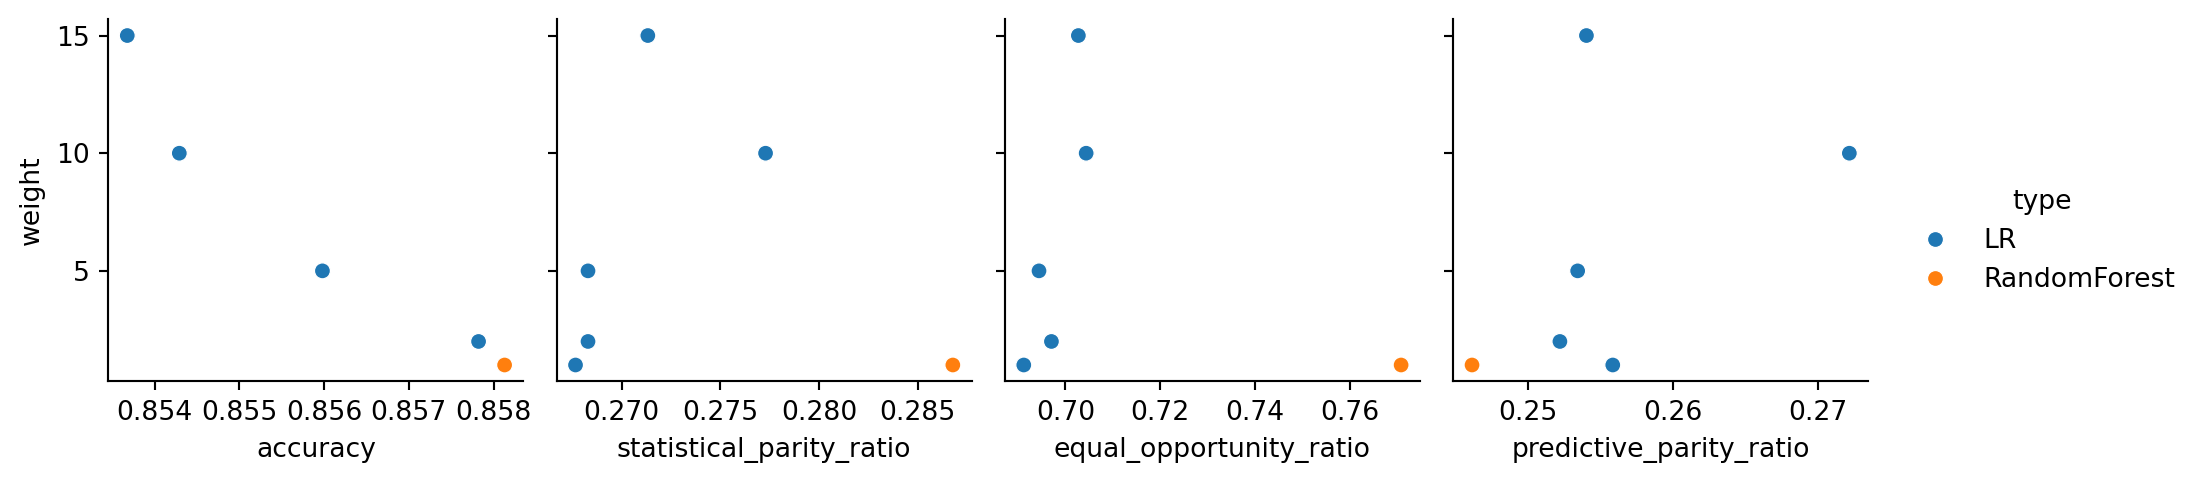

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df, hue="type", y_vars=["weight"], x_vars=['accuracy', "statistical_parity_ratio", "equal_opportunity_ratio", "predictive_parity_ratio"])
plt.show()